[View in Colaboratory](https://colab.research.google.com/github/chokkan/deeplearning/blob/master/notebook/rnn.ipynb)

# Deep Neural Networks for structual input



## Download the dataset

In [0]:
!wget https://download.pytorch.org/tutorial/data.zip

--2018-07-26 12:29:06--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.32.80.97, 13.32.80.66, 13.32.80.22, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.32.80.97|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   2.75M  2.87MB/s    in 1.0s    

2018-07-26 12:29:08 (2.87 MB/s) - ‘data.zip’ saved [2882130/2882130]



In [0]:
!unzip data.zip

Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/Italian.txt  
  inflating: data/names/Japanese.txt  
  inflating: data/names/Korean.txt   
  inflating: data/names/Polish.txt   
  inflating: data/names/Portuguese.txt  
  inflating: data/names/Russian.txt  
  inflating: data/names/Scottish.txt  
  inflating: data/names/Spanish.txt  
  inflating: data/names/Vietnamese.txt  


## Normalize name spellings in the dataset

In [0]:
import string
import unicodedata

# Alphabet [a-zA-Z .,;']
alphabet = set(string.ascii_letters + " .,;'")

def normalize(s):
    # Apply canonical decomposition, and ignore non-alphabet symbols.
    return ''.join(
        c for c in unicodedata.normalize('NFD', s) if c in alphabet
        )

In [0]:
normalize('Ślusàrski')

'Slusarski'

In [0]:
import glob
import json
import os

data = []
srcs = glob.glob('data/names/*.txt')
for src in srcs:
    lang = os.path.basename(src)[:-4]
    for line in open(src):
        line = line.strip('\n')
        data.append((normalize(line), lang))
    
with open('names.json', 'w') as fo:
    json.dump(data, fo)

## Convert the string data into numerical data

In [0]:
def find_vocabulary(data):
    X, Y = set(), set()    
    for (x, y) in data:
        X.update(c for c in x)
        Y.add(y)
    return sorted(X), sorted(Y)

def build_mapping(items):
    M = {}
    for item in items:
        M.setdefault(item, len(M))
    return M

def convert_to_numeric_data(data, Xmap, Ymap):
    D = []
    for (x, y) in data:
        D.append(([Xmap[c] for c in x], Ymap[y]))
    return D    

import json
data = json.load(open('names.json'))

X, Y = find_vocabulary(data)
Xmap = build_mapping(X)
Ymap = build_mapping(Y)

with open('names.data.json', 'w') as fo:
    json.dump(dict(
        data = convert_to_numeric_data(data, Xmap, Ymap),
        X = X,
        Y = Y,
        ), fo)

## Install necessary modules

In [0]:
!pip install livelossplot

  Running setup.py bdist_wheel for livelossplot ... - \ done
  Stored in directory: /content/.cache/pip/wheels/67/8b/e9/3990164e3b2a421145b9d9d76fc8aa889225d495b043faeb73
Successfully built livelossplot


In [0]:
!pip install torch torchvision

    100% |████████████████████████████████| 484.0MB 25kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x5b39e000 @  0x7fafb3ae41c4 0x46d6a4 0x5fcbcc 0x4c494d 0x54f3c4 0x553aaf 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54e4c8
    100% |████████████████████████████████| 61kB 1.6MB/s 
    100% |████████████████████████████████| 2.0MB 2.5MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


## Implementing RNN cells (states)

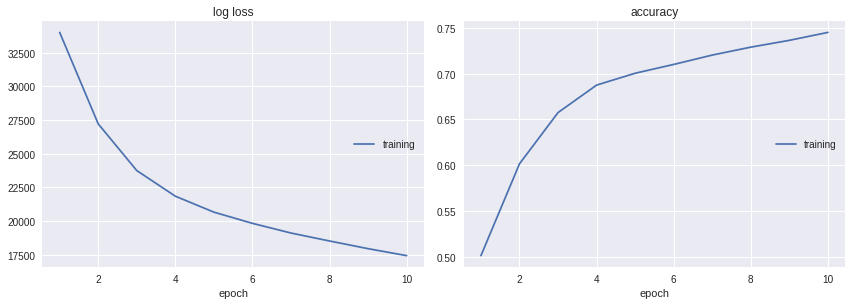

Accuracy: 0.7449 (train)


In [0]:
import json
import random
import torch
import torch.nn as nn
import torch.optim as optim
from livelossplot import PlotLosses

class RNNCell(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNCell, self).__init__()
        
        self.hidden_size = hidden_size
        self.f = nn.Tanh()
        self.hi = nn.Linear(input_size + hidden_size, hidden_size)
        self.oh = nn.Linear(hidden_size, output_size)
    
    def forward(self, input, hidden):
        new_hidden = self.f(self.hi(torch.cat((input, hidden), 0)))
        new_output = self.oh(new_hidden)
        return new_output, new_hidden
    
    def initHidden(self):
        return torch.zeros(self.hidden_size)
    
def x_to_tensor(x, input_size):
    tensor = torch.zeros(len(x), input_size, dtype=torch.float)
    for i, j in enumerate(x):
        tensor[i][j] = 1
    return tensor

def y_to_tensor(y):
    tensor = torch.zeros(1, dtype=torch.long)
    tensor[0] = y
    return tensor

data = json.load(open('names.data.json'))
dataset = data['data']
input_size = len(data['X'])
output_size = len(data['Y'])

model = RNNCell(input_size, 128, output_size)

loss_fn = nn.CrossEntropyLoss(size_average=False)
optimizer = optim.SGD(model.parameters(), lr=0.001)

liveloss = PlotLosses()
for t in range(10):
    train_loss = 0.
    num_train_correct = 0
    random.shuffle(dataset)
    
    # Training loop for every instance.
    for (x, y) in dataset:
        # Convert a training instance into tensors in place.
        x = x_to_tensor(x, input_size)
        y = y_to_tensor(y)
        
        # Recurrent Neural Network
        hidden = model.initHidden()
        for xt in x:
            output, hidden = model(xt, hidden)
                
        # Make predictions with the current parameters.
        y_pred = output.view(1, -1)  # Reshape the output: (18) -> (1, 18)
        _, predicted = torch.max(y_pred.data, 1)
        num_train_correct += (predicted == y).sum().item()
        
        # Compute the loss value.
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        
        # Update the parameters.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
                
    # Visualize accuracy values on the training set.
    num_train_correct /= float(len(dataset))
    liveloss.update({
        'log loss': train_loss,
        'accuracy': num_train_correct,
    })
    liveloss.draw()
    
print('Accuracy: {:.4f} (train)'.format(num_train_correct))

## Using `nn.RNN` module

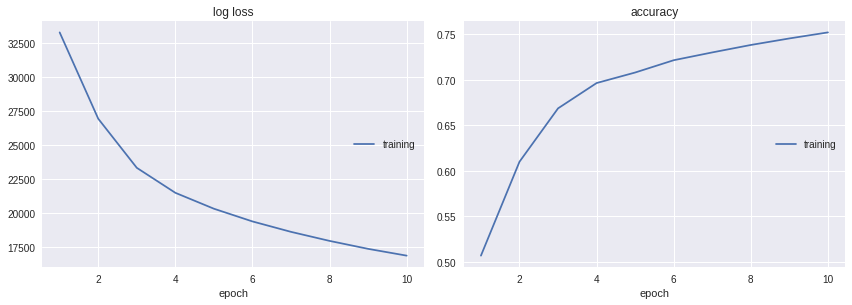

Accuracy: 0.7518 (train)


In [0]:
import json
import random
import torch
import torch.nn as nn
import torch.optim as optim
from livelossplot import PlotLosses

class SequenceRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SequenceRNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, num_layers=1)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, input, hidden):
        output, hidden = self.rnn(input, hidden)
        output = self.fc(output[-1])
        return output
    
    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size)
    
def x_to_tensor(x, input_size):
    tensor = torch.zeros(len(x), 1, input_size, dtype=torch.float)
    for i, j in enumerate(x):
        tensor[i][0][j] = 1   # (T, batch, input_dim)
    return tensor

def y_to_tensor(y):
    tensor = torch.zeros(1, dtype=torch.long)
    tensor[0] = y
    return tensor

data = json.load(open('names.data.json'))
dataset = data['data']
input_size = len(data['X'])
output_size = len(data['Y'])

model = SequenceRNN(input_size, 128, output_size)

loss_fn = nn.CrossEntropyLoss(size_average=False)
optimizer = optim.SGD(model.parameters(), lr=0.001)

liveloss = PlotLosses()
for t in range(10):
    train_loss = 0.
    num_train_correct = 0
    random.shuffle(dataset)
    
    # Training loop for every instance.
    for (x, y) in dataset:
        # Convert a training instance into tensors in place.
        x = x_to_tensor(x, input_size)
        y = y_to_tensor(y)
        
        # Make predictions with the current parameters.
        y_pred = model(x, model.initHidden())
        _, predicted = torch.max(y_pred.data, 1)
        num_train_correct += (predicted == y).sum().item()
        
        # Compute the loss value.
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        
        # Update the parameters.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # Visualize accuracy values on the training set.
    num_train_correct /= float(len(dataset))
    liveloss.update({
        'log loss': train_loss,
        'accuracy': num_train_correct,
    })
    liveloss.draw()
    
print('Accuracy: {:.4f} (train)'.format(num_train_correct))

### Predict a nationality of a name by using the trained model

In [0]:
def predict(name):
    x = []
    for c in name:
        x.append(data['X'].index(c))
    x = x_to_tensor(x, len(data['X']))
    hidden = model.initHidden()
    y_pred = nn.Softmax(dim=-1)(model(x, hidden))
   
    scores = []
    for index, lang in enumerate(data['Y']):
        scores.append((lang, float(y_pred[0][index])))
        
    return sorted(scores, key=lambda x: x[1], reverse=True)

In [0]:
predict('Okazaki')

[('Japanese', 0.9461427927017212),
 ('Russian', 0.03185621649026871),
 ('Polish', 0.010414058342576027),
 ('Czech', 0.003833773313090205),
 ('Arabic', 0.003288869746029377),
 ('Greek', 0.0009786260779947042),
 ('Italian', 0.0008207539794966578),
 ('Irish', 0.0006575745064765215),
 ('Spanish', 0.0004893130389973521),
 ('Dutch', 0.00032580405240878463),
 ('Portuguese', 0.0003188259433954954),
 ('French', 0.0002976279938593507),
 ('Vietnamese', 0.00018134928541257977),
 ('German', 0.0001374820276396349),
 ('Scottish', 9.472124656895176e-05),
 ('Chinese', 6.228135316632688e-05),
 ('English', 6.030905569787137e-05),
 ('Korean', 3.963872222811915e-05)]

## Mini-batch RNN

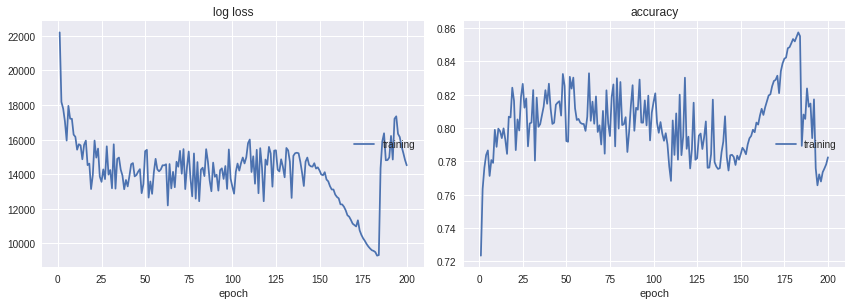

Accuracy: 0.7824 (train)


In [0]:
import json
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from livelossplot import PlotLosses

class MinibatchSequenceRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MinibatchSequenceRNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def last_timestep(self, unpacked, lengths):
        idx = (lengths-1).view(-1, 1).expand(
            unpacked.size(0), unpacked.size(2)).unsqueeze(1)
        return unpacked.gather(1, idx).squeeze()
    
    def forward(self, input, hidden, l):
        input = nn.utils.rnn.pack_padded_sequence(input, l, batch_first=True)
        output, hidden = self.rnn(input, hidden)
        output, _ = nn.utils.rnn.pad_packed_sequence(output, batch_first=True)
        output = self.last_timestep(output, l)
        output = self.fc(output)
        return output
    
    def initHidden(self, batch_size=1):
        return torch.zeros(1, batch_size, self.hidden_size)
    
def create_dataset(data, X, Y):
    # Sort the data by sequence length (long to short)
    data.sort(key=lambda instance: len(instance[0]), reverse=True)
    
    input_size = len(X)
    output_size = len(Y)
    max_length = len(data[0][0])
    num_instances = len(data)
    
    xt = torch.zeros(num_instances, max_length, input_size, dtype=torch.float)
    yt = torch.zeros(num_instances, dtype=torch.long)
    lt = torch.zeros(num_instances, dtype=torch.long)
                    
    for i, (x, y) in enumerate(data):
        for t, v in enumerate(x):
            xt[i][t][v] = 1
        yt[i] = y
        lt[i] = len(x)
    return TensorDataset(xt, yt, lt)

batch_size = 32
data = json.load(open('names.data.json'))
train_set = create_dataset(data['data'], data['X'], data['Y'])
train_loader = DataLoader(train_set, batch_size=batch_size)
input_size = len(data['X'])
output_size = len(data['Y'])

model = MinibatchSequenceRNN(input_size, 128, output_size)

loss_fn = nn.CrossEntropyLoss(size_average=False)
optimizer = optim.SGD(model.parameters(), lr=1e-3)

liveloss = PlotLosses()
for t in range(200):
    train_loss = 0.
    num_train_correct = 0
    
    # Training loop for mini-batches
    for batch_idx, (x, y, l) in enumerate(train_loader):
        this_batch_size = len(l)
        
        # Make predictions with the current parameters.
        hidden = model.initHidden(this_batch_size)
        y_pred = model(x, hidden, l)[:this_batch_size]
        _, predicted = torch.max(y_pred.data, 1)
        num_train_correct += (predicted == y).sum().item()
        
        # Compute the loss value.
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        
        # Update the parameters.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # Visualize accuracy values on the training set.
    num_train_correct /= float(len(train_set))
    liveloss.update({
        'log loss': train_loss,
        'accuracy': num_train_correct,
    })
    liveloss.draw()
    
print('Accuracy: {:.4f} (train)'.format(num_train_correct))

## Mini-batch LSTM

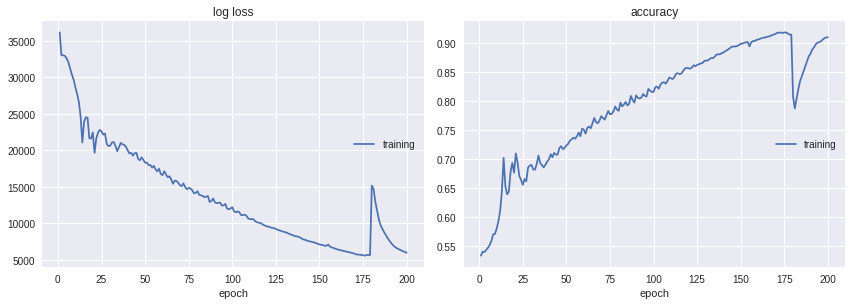

Accuracy: 0.9103 (train)


In [0]:
import json
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from livelossplot import PlotLosses

class MinibatchSequenceRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MinibatchSequenceRNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def last_timestep(self, unpacked, lengths):
        idx = (lengths-1).view(-1, 1).expand(
            unpacked.size(0), unpacked.size(2)).unsqueeze(1)
        return unpacked.gather(1, idx).squeeze()
    
    def forward(self, input, hidden, l):
        input = nn.utils.rnn.pack_padded_sequence(input, l, batch_first=True)
        output, hidden = self.rnn(input, hidden)
        output, _ = nn.utils.rnn.pad_packed_sequence(output, batch_first=True)
        output = self.last_timestep(output, l)
        output = self.fc(output)
        return output
    
    def initHidden(self, batch_size=1):
        return (
            torch.zeros(1, batch_size, self.hidden_size),
            torch.zeros(1, batch_size, self.hidden_size)
        )
    
def create_dataset(data, X, Y):
    # Sort the data by sequence length (long to short)
    data.sort(key=lambda instance: len(instance[0]), reverse=True)
    
    input_size = len(X)
    output_size = len(Y)
    max_length = len(data[0][0])
    num_instances = len(data)
    
    xt = torch.zeros(num_instances, max_length, input_size, dtype=torch.float)
    yt = torch.zeros(num_instances, dtype=torch.long)
    lt = torch.zeros(num_instances, dtype=torch.long)
                    
    for i, (x, y) in enumerate(data):
        for t, v in enumerate(x):
            xt[i][t][v] = 1
        yt[i] = y
        lt[i] = len(x)
    return TensorDataset(xt, yt, lt)

batch_size = 32
data = json.load(open('names.data.json'))
train_set = create_dataset(data['data'], data['X'], data['Y'])
train_loader = DataLoader(train_set, batch_size=batch_size)
input_size = len(data['X'])
output_size = len(data['Y'])

model = MinibatchSequenceRNN(input_size, 128, output_size)

loss_fn = nn.CrossEntropyLoss(size_average=False)
optimizer = optim.SGD(model.parameters(), lr=1e-3)

liveloss = PlotLosses()
for t in range(200):
    train_loss = 0.
    num_train_correct = 0
    
    # Training loop for mini-batches
    for batch_idx, (x, y, l) in enumerate(train_loader):
        this_batch_size = len(l)
        
        # Make predictions with the current parameters.
        hidden = model.initHidden(this_batch_size)
        y_pred = model(x, hidden, l)[:this_batch_size]
        _, predicted = torch.max(y_pred.data, 1)
        num_train_correct += (predicted == y).sum().item()
        
        # Compute the loss value.
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        
        # Update the parameters.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # Visualize accuracy values on the training set.
    num_train_correct /= float(len(train_set))
    liveloss.update({
        'log loss': train_loss,
        'accuracy': num_train_correct,
    })
    liveloss.draw()
    
print('Accuracy: {:.4f} (train)'.format(num_train_correct))

## Mini-batch GRU

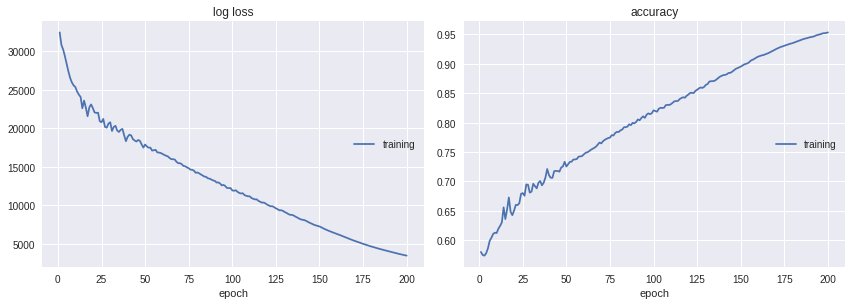

Accuracy: 0.9532 (train)


In [0]:
import json
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from livelossplot import PlotLosses

class MinibatchSequenceRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MinibatchSequenceRNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.rnn = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def last_timestep(self, unpacked, lengths):
        idx = (lengths-1).view(-1, 1).expand(
            unpacked.size(0), unpacked.size(2)).unsqueeze(1)
        return unpacked.gather(1, idx).squeeze()
    
    def forward(self, input, hidden, l):
        input = nn.utils.rnn.pack_padded_sequence(input, l, batch_first=True)
        output, hidden = self.rnn(input, hidden)
        output, _ = nn.utils.rnn.pad_packed_sequence(output, batch_first=True)
        output = self.last_timestep(output, l)
        output = self.fc(output)
        return output
    
    def initHidden(self, batch_size=1):
        return torch.zeros(1, batch_size, self.hidden_size)
    
def create_dataset(data, X, Y):
    # Sort the data by sequence length (long to short)
    data.sort(key=lambda instance: len(instance[0]), reverse=True)
    
    input_size = len(X)
    output_size = len(Y)
    max_length = len(data[0][0])
    num_instances = len(data)
    
    xt = torch.zeros(num_instances, max_length, input_size, dtype=torch.float)
    yt = torch.zeros(num_instances, dtype=torch.long)
    lt = torch.zeros(num_instances, dtype=torch.long)
                    
    for i, (x, y) in enumerate(data):
        for t, v in enumerate(x):
            xt[i][t][v] = 1
        yt[i] = y
        lt[i] = len(x)
    return TensorDataset(xt, yt, lt)

batch_size = 32
data = json.load(open('names.data.json'))
train_set = create_dataset(data['data'], data['X'], data['Y'])
train_loader = DataLoader(train_set, batch_size=batch_size)
input_size = len(data['X'])
output_size = len(data['Y'])

model = MinibatchSequenceRNN(input_size, 128, output_size)

loss_fn = nn.CrossEntropyLoss(size_average=False)
optimizer = optim.SGD(model.parameters(), lr=1e-3)

liveloss = PlotLosses()
for t in range(200):
    train_loss = 0.
    num_train_correct = 0
    
    # Training loop for mini-batches
    for batch_idx, (x, y, l) in enumerate(train_loader):
        this_batch_size = len(l)
        
        # Make predictions with the current parameters.
        hidden = model.initHidden(this_batch_size)
        y_pred = model(x, hidden, l)[:this_batch_size]
        _, predicted = torch.max(y_pred.data, 1)
        num_train_correct += (predicted == y).sum().item()
        
        # Compute the loss value.
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        
        # Update the parameters.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # Visualize accuracy values on the training set.
    num_train_correct /= float(len(train_set))
    liveloss.update({
        'log loss': train_loss,
        'accuracy': num_train_correct,
    })
    liveloss.draw()
    
print('Accuracy: {:.4f} (train)'.format(num_train_correct))